# Monet Style Image Generation using CycleGAN

This notebook demonstrates how to build and train a Generative Adversarial Network (GAN), specifically a CycleGAN, to transform landscape photographs into the style of Claude Monet paintings.

## 1. Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa # For Instance Normalization
from tensorflow.python.compiler.mlcompute import mlcompute

import matplotlib.pyplot as plt
import numpy as np
import time
import os

/opt/homebrew/Caskroom/miniforge/base/envs/mtf/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
BUFFER_SIZE = 1000 
BATCH_SIZE = 1    
IMG_WIDTH = 256 
IMG_HEIGHT = 256  
OUTPUT_CHANNELS = 3 
LAMBDA_CYCLE = 10   
LAMBDA_IDENTITY = 0.5 * LAMBDA_CYCLE 
EPOCHS = 25 

## 2. Data Loading & Preprocessing

In [3]:
MONET_PATH = "~/gan-getting-started/monet_jpg"
PHOTO_PATH = "~/gan-getting-started/photo_jpg"

In [4]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=OUTPUT_CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image - 0.5) * 2
    return image

def create_dataset(path):
    file_pattern = os.path.join(path, '*.jpg')
    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=False) 

    if tf.data.experimental.cardinality(dataset) == 0:
        print(f"Warning: No .jpg files found in directory: {path}")
        return None 

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

2025-04-26 21:59:53.110654: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 21:59:53.110688: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-26 21:59:53.110693: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-26 21:59:53.110733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 21:59:53.110749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


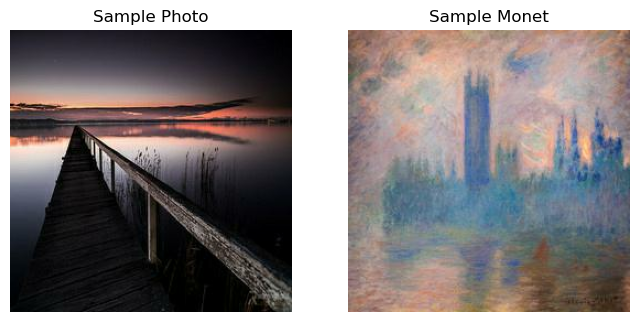

In [5]:
photo_dataset = create_dataset(PHOTO_PATH)
monet_dataset = create_dataset(MONET_PATH)

try:
    sample_photo = next(iter(photo_dataset))
    sample_monet = next(iter(monet_dataset))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Sample Photo")
    plt.imshow(sample_photo[0] * 0.5 + 0.5) 
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Sample Monet")
    plt.imshow(sample_monet[0] * 0.5 + 0.5) 
    plt.axis('off')
    plt.show()
except StopIteration:
     print("Could not retrieve samples. Datasets might be empty or loading failed.")
except Exception as e:
    print(f"An error occurred while displaying samples: {e}")

## 3. Model Definition

In [6]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [7]:
def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS])

    down_stack = [
        downsample(64, 4, apply_norm=False), 
        downsample(128, 4),                
        downsample(256, 4),          
        downsample(512, 4),               
        downsample(512, 4),               
        downsample(512, 4),               
        downsample(512, 4),               
        downsample(512, 4),               
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),                   
        upsample(256, 4),     
        upsample(128, 4),               
        upsample(64, 4),                   
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1]) 

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x) 

    return keras.Model(inputs=inputs, outputs=x)

In [8]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS], name='input_image')

    down1 = downsample(64, 4, False)(inp) 
    down2 = downsample(128, 4)(down1)  
    down3 = downsample(256, 4)(down2)   

    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [9]:
generator_g = build_generator()   
generator_f = build_generator()    
discriminator_x = build_discriminator()
discriminator_y = build_discriminator() 

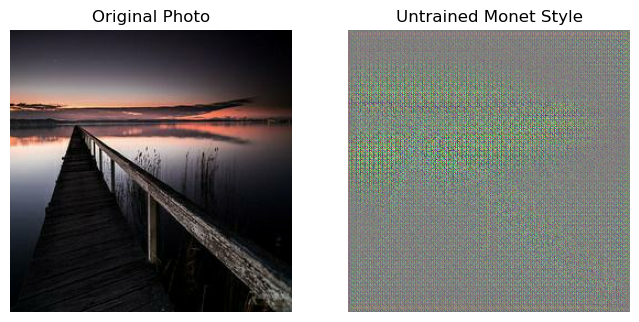

In [10]:
try:
    if photo_dataset is not None:
        to_monet = generator_g(sample_photo)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.title("Original Photo")
        plt.imshow(sample_photo[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title("Untrained Monet Style")
        plt.imshow(to_monet[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
    else:
        print("Skipping untrained generator visualization as photo dataset failed to load.")
except NameError:
    print("Sample photo not defined, likely due to dataset loading issues.")
except Exception as e:
    print(f"An error occurred during untrained generator visualization: {e}")

## 4. Loss Functions

In [11]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)      
    generated_loss = loss_obj(tf.zeros_like(generated), generated) 
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss1

def calc_identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_IDENTITY * loss

## 5. Training

In [12]:
generator_g_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [13]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [14]:
@tf.function # Compile into a TensorFlow graph for performance
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True) 

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True) 

        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)

        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y) 
        gen_f_loss = generator_loss(disc_fake_x) 

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + calc_identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + calc_identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss,
        "cycle_loss": total_cycle_loss,
    }


Starting training for 25 epochs...


2025-04-26 22:00:13.437393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


...
Time taken for epoch 1 is 218.877849817276 sec
  Avg Gen G Loss: 5.1952, Avg Gen F Loss: 5.2063
  Avg Disc X Loss: 0.6996, Avg Disc Y Loss: 0.6918
  Avg Cycle Loss: 3.5697


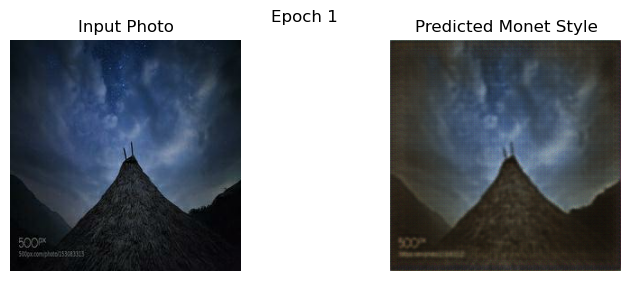

...
Time taken for epoch 2 is 203.1896848678589 sec
  Avg Gen G Loss: 3.6387, Avg Gen F Loss: 3.6426
  Avg Disc X Loss: 0.6678, Avg Disc Y Loss: 0.6589
  Avg Cycle Loss: 2.2467


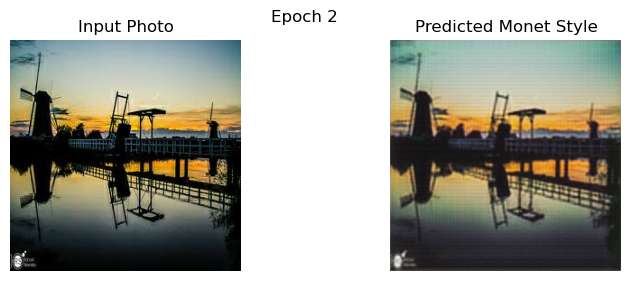

...
Time taken for epoch 3 is 209.06957483291626 sec
  Avg Gen G Loss: 3.3736, Avg Gen F Loss: 3.3782
  Avg Disc X Loss: 0.6524, Avg Disc Y Loss: 0.6481
  Avg Cycle Loss: 2.0035


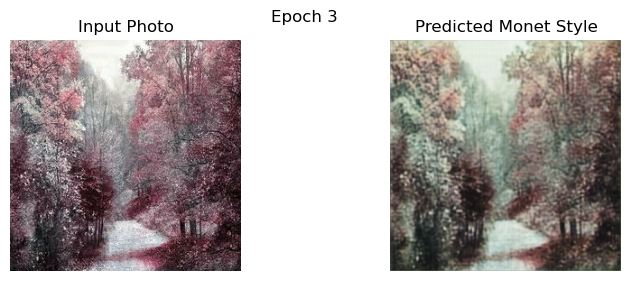

...
Time taken for epoch 4 is 227.34056496620178 sec
  Avg Gen G Loss: 3.2210, Avg Gen F Loss: 3.2409
  Avg Disc X Loss: 0.6531, Avg Disc Y Loss: 0.6446
  Avg Cycle Loss: 1.8955


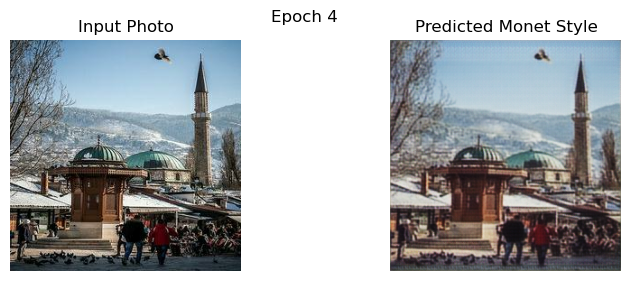

...
Time taken for epoch 5 is 251.8473150730133 sec
  Avg Gen G Loss: 3.1220, Avg Gen F Loss: 3.1516
  Avg Disc X Loss: 0.6384, Avg Disc Y Loss: 0.6365
  Avg Cycle Loss: 1.7811


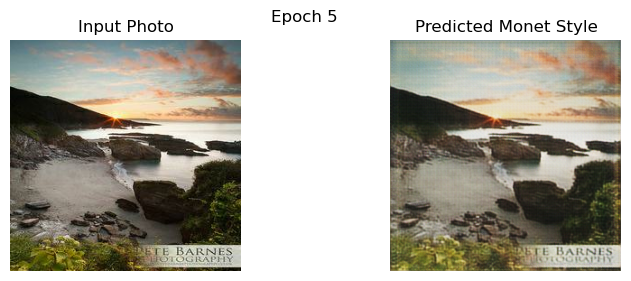

...
Time taken for epoch 6 is 273.3126890659332 sec
  Avg Gen G Loss: 2.9970, Avg Gen F Loss: 3.0317
  Avg Disc X Loss: 0.6467, Avg Disc Y Loss: 0.6427
  Avg Cycle Loss: 1.6861


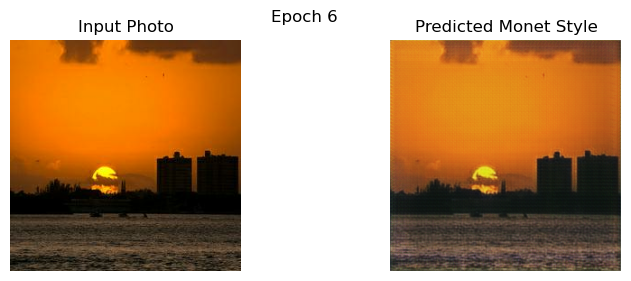

...
Time taken for epoch 7 is 265.75725078582764 sec
  Avg Gen G Loss: 2.7873, Avg Gen F Loss: 2.8144
  Avg Disc X Loss: 0.6440, Avg Disc Y Loss: 0.6461
  Avg Cycle Loss: 1.5327


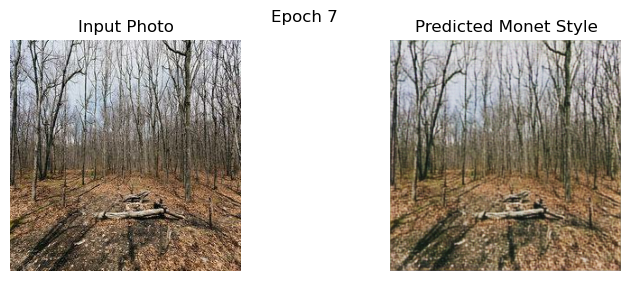

...
Time taken for epoch 8 is 239.42588806152344 sec
  Avg Gen G Loss: 2.7950, Avg Gen F Loss: 2.8577
  Avg Disc X Loss: 0.6340, Avg Disc Y Loss: 0.6370
  Avg Cycle Loss: 1.5191


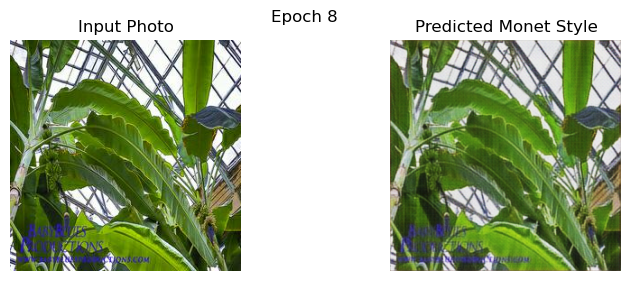

...
Time taken for epoch 9 is 231.90080094337463 sec
  Avg Gen G Loss: 2.7150, Avg Gen F Loss: 2.7527
  Avg Disc X Loss: 0.6339, Avg Disc Y Loss: 0.6289
  Avg Cycle Loss: 1.4381


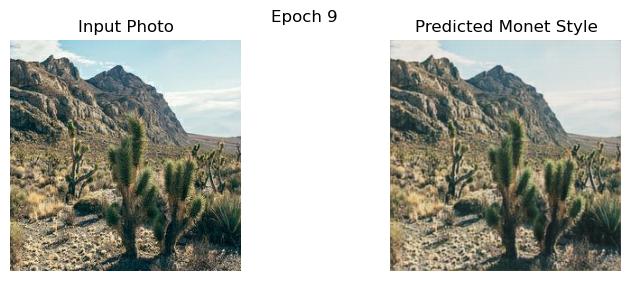

...
Time taken for epoch 10 is 250.03235793113708 sec
  Avg Gen G Loss: 2.7240, Avg Gen F Loss: 2.7831
  Avg Disc X Loss: 0.6261, Avg Disc Y Loss: 0.6378
  Avg Cycle Loss: 1.4609


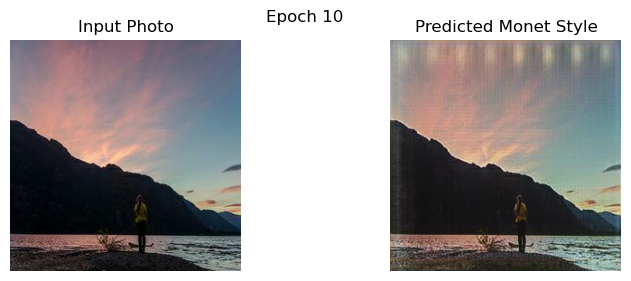

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-1
...
Time taken for epoch 11 is 230.25430989265442 sec
  Avg Gen G Loss: 2.6612, Avg Gen F Loss: 2.7208
  Avg Disc X Loss: 0.6269, Avg Disc Y Loss: 0.6334
  Avg Cycle Loss: 1.4075


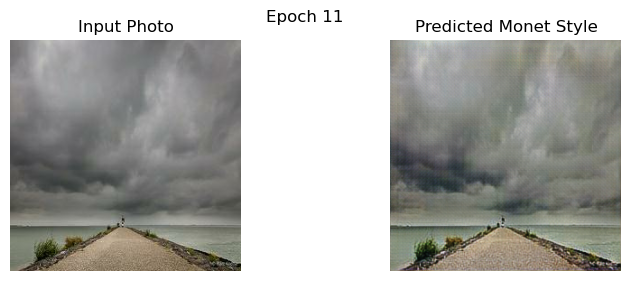

...
Time taken for epoch 12 is 232.14691495895386 sec
  Avg Gen G Loss: 2.6419, Avg Gen F Loss: 2.7190
  Avg Disc X Loss: 0.6196, Avg Disc Y Loss: 0.6329
  Avg Cycle Loss: 1.3950


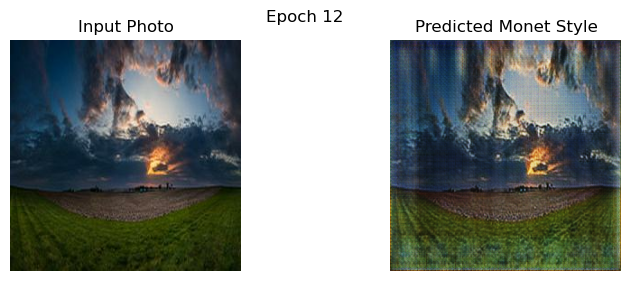

...
Time taken for epoch 13 is 447.6566107273102 sec
  Avg Gen G Loss: 2.6297, Avg Gen F Loss: 2.7075
  Avg Disc X Loss: 0.6303, Avg Disc Y Loss: 0.6419
  Avg Cycle Loss: 1.4077


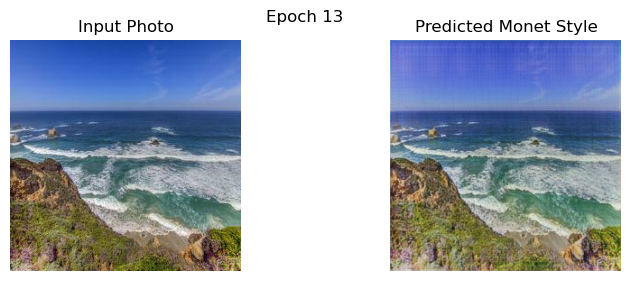

...
Time taken for epoch 14 is 346.4748089313507 sec
  Avg Gen G Loss: 2.5803, Avg Gen F Loss: 2.6673
  Avg Disc X Loss: 0.6197, Avg Disc Y Loss: 0.6373
  Avg Cycle Loss: 1.3730


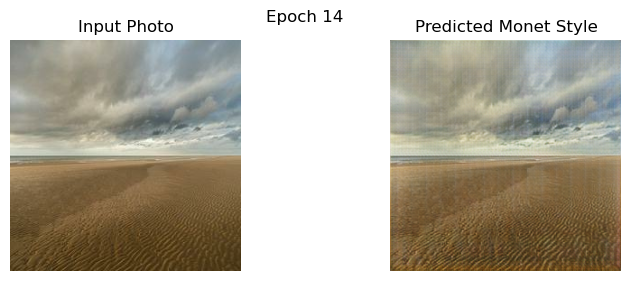

...
Time taken for epoch 15 is 215.13146114349365 sec
  Avg Gen G Loss: 2.5489, Avg Gen F Loss: 2.6448
  Avg Disc X Loss: 0.6153, Avg Disc Y Loss: 0.6421
  Avg Cycle Loss: 1.3656


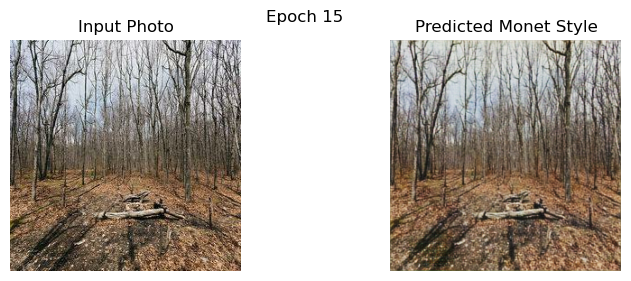

...
Time taken for epoch 16 is 235.96011900901794 sec
  Avg Gen G Loss: 2.5385, Avg Gen F Loss: 2.6545
  Avg Disc X Loss: 0.6196, Avg Disc Y Loss: 0.6442
  Avg Cycle Loss: 1.3768


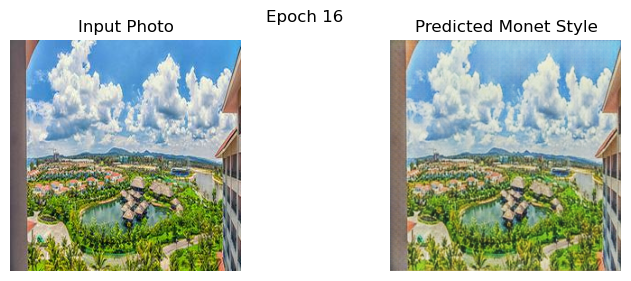

...
Time taken for epoch 17 is 323.5257568359375 sec
  Avg Gen G Loss: 2.5782, Avg Gen F Loss: 2.7165
  Avg Disc X Loss: 0.6152, Avg Disc Y Loss: 0.6489
  Avg Cycle Loss: 1.4153


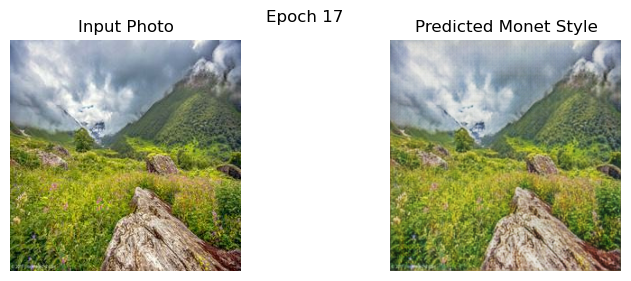

...
Time taken for epoch 18 is 315.42813897132874 sec
  Avg Gen G Loss: 2.4682, Avg Gen F Loss: 2.5951
  Avg Disc X Loss: 0.6240, Avg Disc Y Loss: 0.6552
  Avg Cycle Loss: 1.3528


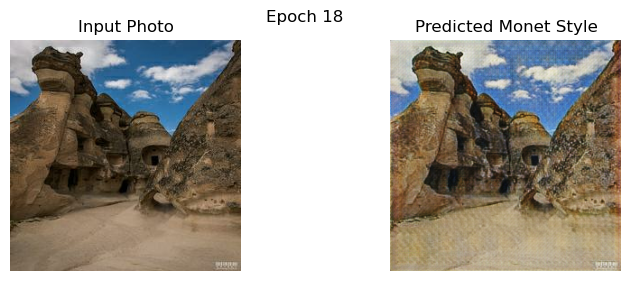

...
Time taken for epoch 19 is 317.9405288696289 sec
  Avg Gen G Loss: 2.6687, Avg Gen F Loss: 2.8164
  Avg Disc X Loss: 0.6122, Avg Disc Y Loss: 0.6429
  Avg Cycle Loss: 1.4914


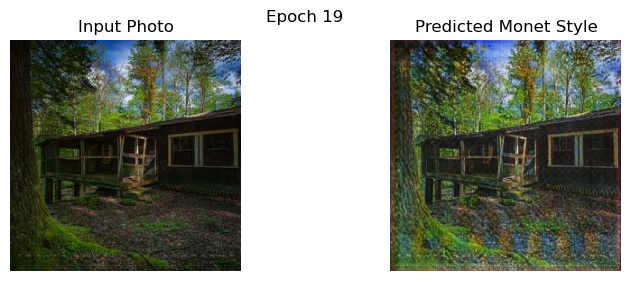

...
Time taken for epoch 20 is 313.3286793231964 sec
  Avg Gen G Loss: 2.4691, Avg Gen F Loss: 2.6288
  Avg Disc X Loss: 0.6238, Avg Disc Y Loss: 0.6594
  Avg Cycle Loss: 1.3735


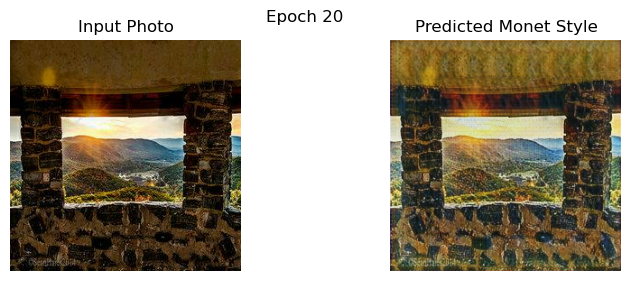

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-2
...
Time taken for epoch 21 is 262.0791220664978 sec
  Avg Gen G Loss: 2.7154, Avg Gen F Loss: 2.7537
  Avg Disc X Loss: 0.6218, Avg Disc Y Loss: 0.6241
  Avg Cycle Loss: 1.4892


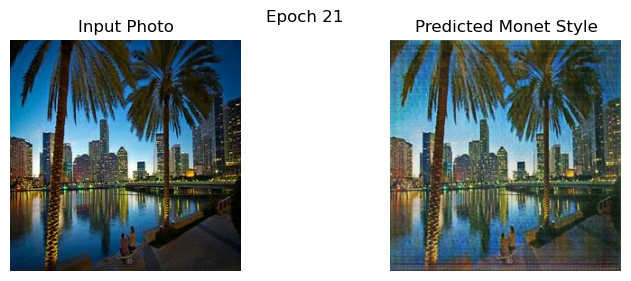

...
Time taken for epoch 22 is 274.983274936676 sec
  Avg Gen G Loss: 2.6195, Avg Gen F Loss: 2.6534
  Avg Disc X Loss: 0.6287, Avg Disc Y Loss: 0.6452
  Avg Cycle Loss: 1.4281


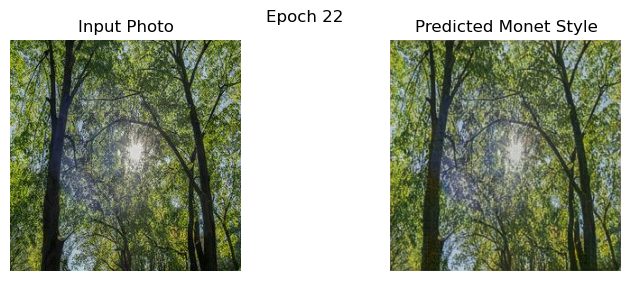

...
Time taken for epoch 23 is 272.26071310043335 sec
  Avg Gen G Loss: 2.5529, Avg Gen F Loss: 2.6215
  Avg Disc X Loss: 0.6309, Avg Disc Y Loss: 0.6476
  Avg Cycle Loss: 1.4167


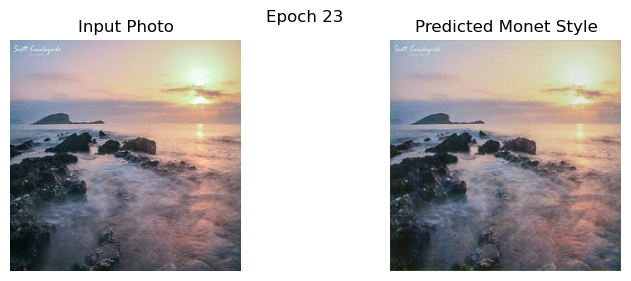

...
Time taken for epoch 24 is 272.84079599380493 sec
  Avg Gen G Loss: 2.4719, Avg Gen F Loss: 2.5373
  Avg Disc X Loss: 0.6211, Avg Disc Y Loss: 0.6502
  Avg Cycle Loss: 1.3428


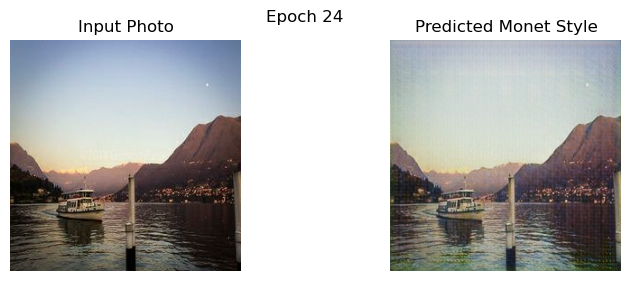

...
Time taken for epoch 25 is 264.04835772514343 sec
  Avg Gen G Loss: 2.4750, Avg Gen F Loss: 2.5389
  Avg Disc X Loss: 0.6321, Avg Disc Y Loss: 0.6557
  Avg Cycle Loss: 1.3585


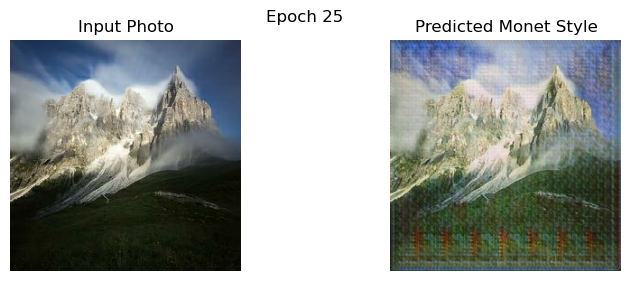


Total training time: 6717.47 seconds
Training finished.


In [15]:
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    n = 0
    epoch_losses = {"gen_g_loss": 0.0, "gen_f_loss": 0.0, "disc_x_loss": 0.0, "disc_y_loss": 0.0, "cycle_loss": 0.0}

    for image_x, image_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        losses = train_step(image_x, image_y)

        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        n += 1

        if n % 100 == 0:
            print ('.', end='')

    for key in epoch_losses:
        epoch_losses[key] /= n

    print ('\nTime taken for epoch {} is {} sec'.format(epoch + 1, time.time()-epoch_start_time))
    print(f"  Avg Gen G Loss: {epoch_losses['gen_g_loss']:.4f}, Avg Gen F Loss: {epoch_losses['gen_f_loss']:.4f}")
    print(f"  Avg Disc X Loss: {epoch_losses['disc_x_loss']:.4f}, Avg Disc Y Loss: {epoch_losses['disc_y_loss']:.4f}")
    print(f"  Avg Cycle Loss: {epoch_losses['cycle_loss']:.4f}")


    if (epoch + 1) % 1 == 0: 
         try:
            sample_photo_batch = next(iter(photo_dataset)) 
            prediction = generator_g(sample_photo_batch, training=False)

            plt.figure(figsize=(9, 3))

            display_list = [sample_photo_batch[0], prediction[0]]
            title = ['Input Photo', 'Predicted Monet Style']

            for i in range(2):
                plt.subplot(1, 2, i+1)
                plt.title(title[i])
                plt.imshow(display_list[i] * 0.5 + 0.5)
                plt.axis('off')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.show()
         except StopIteration:
             print("Warning: Could not generate sample image, dataset iterator exhausted.")
         except Exception as e:
             print(f"Error generating sample image: {e}")


    if (epoch + 1) % 10 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

print(f"\nTotal training time: {time.time() - start_time:.2f} seconds")

## 6. Generation

In [16]:
os.mkdir("~/gan-getting-started/images")

for file in os.listdir(PHOTO_PATH):
    path = PHOTO_PATH + f"/{file}"
    
    dat = generator_g(tf.expand_dims(load_image(path), 0), training=False)
    tf.keras.preprocessing.image.save_img(f"~/gan-getting-started/images/{file}", dat[0])


Generating Monet style for image: /Users/saravi/Documents/Data/Master's/gan-getting-started/photo_jpg/0a0c3a6d07.jpg


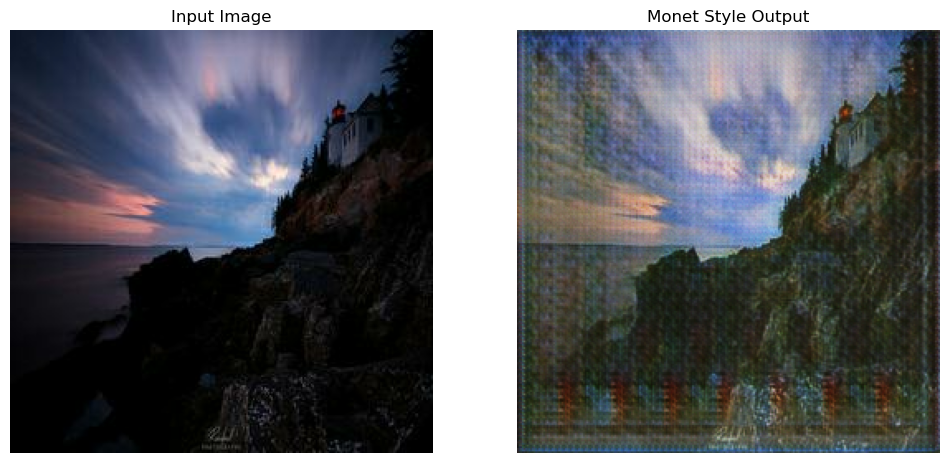


Notebook execution complete.


In [17]:
def generate_monet_style(image_path, generator_model):
    try:
        img = load_image(image_path)
        img = tf.expand_dims(img, 0) 

        prediction = generator_model(img, training=False)[0] 

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Monet Style Output")
        plt.imshow(prediction * 0.5 + 0.5)
        plt.axis('off')

        plt.show()
        

test_image_path = "~/gan-getting-started/photo_jpg/0a0c3a6d07.jpg"
print(f"\nGenerating Monet style for image: {test_image_path}")
generate_monet_style(test_image_path, generator_g)